# Setup

In [1]:
import csv
import math
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score,classification_report, accuracy_score,f1_score
from sklearn.feature_selection import SelectKBest, chi2, RFE

In [2]:
df = pandas.read_csv('matches.csv', na_values = pandas.NA)
print(df.head())
df.info()
df.shape

       Match ID Blue Win First Blood First Dragon First Rift Herald  \
0  4.045184e+09     True        True        False              True   
1  4.045179e+09    False       False          NaN              True   
2  4.045166e+09    False        True        False               NaN   
3  4.045141e+09    False       False        False               NaN   
4  4.042873e+09    False        True        False               NaN   

  First Tower  Blue kills  Red kills  Blue assists  Red assists  Blue gold  \
0         NaN           8          5            13            4      18383   
1         NaN           9          6             9            4      16932   
2         NaN          10         11             8           14      17503   
3         NaN           3          6             6           10      15576   
4         NaN           3         13             2           16      15086   

   Red gold  Gold Diff  Blue towers  Red towers  Blue xp  Red xp  
0     16653       1730            0  

(6661, 17)

There are 6661 observations and 17 characteristics. One of which is the Match ID and one is the dependent variable. 5 of the features have been imported as object data types but need to be converted. We can't make any graphs or build a model using object data types.

# Exploratory Data Analysis

In [3]:
print('{} games were remade, we need to delete these rows since neither team won. '.format(sum(df['Blue Win'] == 'Remake')))
print('There are {} duplicate matches'.format(sum(df.duplicated())))

df = df[df['Blue Win'] != 'Remake']
df = df.drop_duplicates()
df = df.drop('Match ID', axis = 1)

print('There are now {} matches after dropping the duplicates.'.format(df.shape[0]))
df.nunique()

66 games were remade, we need to delete these rows since neither team won. 
There are 1460 duplicate matches
There are now 5200 matches after dropping the duplicates.


Blue Win                2
First Blood             2
First Dragon            2
First Rift Herald       2
First Tower             2
Blue kills             23
Red kills              22
Blue assists           33
Red assists            31
Blue gold            3409
Red gold             3373
Gold Diff            3915
Blue towers             3
Red towers              3
Blue xp              3021
Red xp               2980
dtype: int64

In [4]:
df.loc[df['First Tower'] == 'Blue', 'First Tower'] = True
df.loc[df['First Tower'] == 'Red', 'First Tower'] = False
df['Blue Win'] = df['Blue Win'].map({'False':False, 'True':True})
df['First Blood'] = df['First Blood'].astype(bool)
df['First Dragon'] = df['First Dragon'].astype(float)
df['First Rift Herald'] = df['First Rift Herald'].astype(float)
df['First Tower'] = df['First Tower'].astype(float)

We can change Blue Win and First Blood to boolean data types because there are no missing data points in these features. The other three object data type features; First Dragon, First Rift Herald, and First Tower need to be converted to floats to allow use of NA data points. 

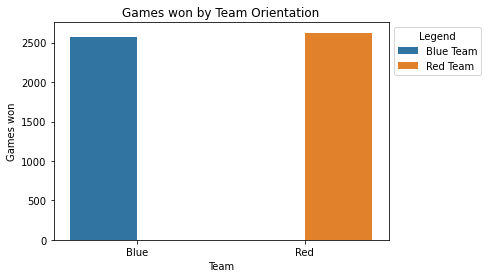

In [5]:
teamcount = sns.countplot(data = df, x = 'Blue Win', hue = 'Blue Win')
teamcount.legend(labels = ['Blue Team','Red Team'], title = 'Legend',bbox_to_anchor = (1,1))
teamcount.set(title = 'Games won by Team Orientation')
teamcount.set(ylabel = 'Games won', xlabel = 'Team')
teamcount.set(xticklabels = ['Blue','Red'])
plt.show(teamcount)

The map in League Of Legends isn't symmetrical, so we should check if there is a significant difference between playing on the Blue side or the Red side. The win rate is very similar therefore it is not likely to be an impactful feature.

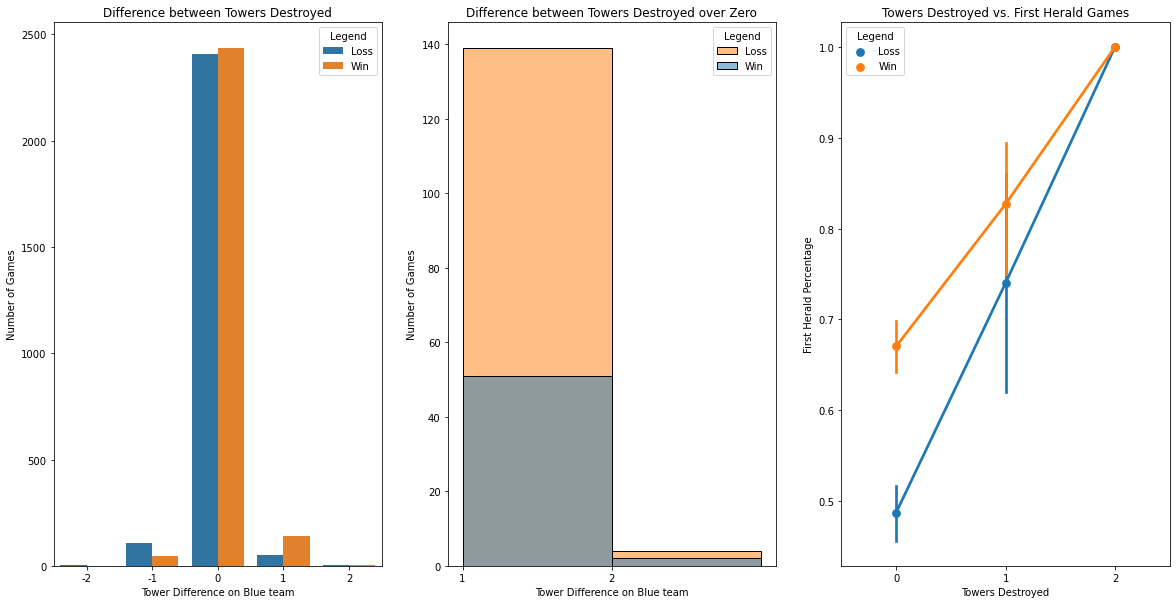

In [6]:
df['Towers Diff'] = df['Blue towers'] - df['Red towers']
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
sns.countplot(data = df, x = 'Towers Diff', hue = 'Blue Win', ax = axes[0])
axes[0].set(ylabel = 'Number of Games', xlabel = 'Tower Difference on Blue team')
axes[0].legend(title = 'Legend',labels = ['Loss', 'Win'])
axes[0].set(title = 'Difference between Towers Destroyed')

sns.histplot(ax = axes[1], data = df, x = 'Towers Diff',binrange = [1,3],bins = 2, hue = 'Blue Win', color = 'RdBlu')
axes[1].set_xticks([1,2])
axes[1].set(ylabel = 'Number of Games', xlabel = 'Tower Difference on Blue team')
axes[1].legend(title = 'Legend',labels = ['Loss', 'Win'])
axes[1].set(title = 'Difference between Towers Destroyed over Zero')


sns.pointplot(ax = axes[2], data = df, x = 'Blue towers', y = 'First Rift Herald', hue = 'Blue Win', kind = 'point')
axes[2].set(ylabel = 'First Herald Percentage', xlabel = 'Towers Destroyed')
axes[2].set(title = 'Towers Destroyed vs. First Herald Games')
h, l = axes[2].get_legend_handles_labels()
axes[2].legend(h, ['Loss', 'Win'], title = "Legend")
plt.show(fig)

The vast majority of games there are no towers destroyed by the 10 minute mark. Because the variation of this feature is so low, it won't be a good predictor. This is compounded by the fact that almost half the teams that have destroyed one more tower than their opponent did not win the game. The Rift Herald is an objective that helps break towers. When we look at winning games, they are more likely to take Rift Herald and destroy a tower. There are no games where two towers were destroyed while the Rift Herald was not taken.

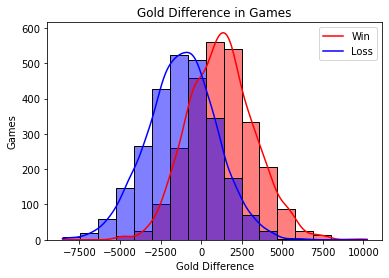

The average and mean gold difference is about 1250.0 when teams win.


In [7]:
gold = sns.histplot(x='Gold Diff', data=df, hue='Blue Win', palette = ['Blue','Red'], kde=True, bins = 17)
gold.set(ylabel = 'Games', xlabel = 'Gold Difference')
gold.set(title = 'Gold Difference in Games')
gold.legend(labels = ['Win','Loss'])
plt.show(gold)
print('The average and mean gold difference is about {} when teams win.'.format(round(df['Gold Diff'].loc[df['Blue Win']].mean(),-1)))

A gold difference of 1250 is about four kills worth of gold without any assists or 3 kills worth of gold with a teammate getting an assist for every kill. I predict gold difference will be the leading predictor in winning games since almost every activity in League of Legends involves collecting gold and stopping your opponent from getting gold. Obtaining Kills, assists, breaking towers, and gaining exp all involve gaining gold.

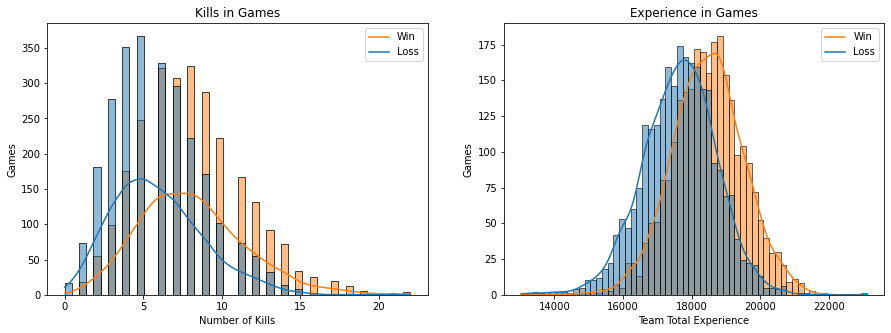

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax = axes[0], x='Blue kills', data=df, hue='Blue Win', kde=True)
axes[0].set(title = 'Kills in Games')
axes[0].set(xlabel = 'Number of Kills', ylabel = 'Games')
axes[0].legend(labels = ['Win','Loss'])
axes[1] = sns.histplot(ax = axes[1], x='Blue xp', data=df, hue='Blue Win', kde=True)
axes[1].set(title = 'Experience in Games')
axes[1].set(xlabel = 'Team Total Experience', ylabel = 'Games')
axes[1].legend(labels = ['Win','Loss'])
plt.show(fig)

The median for kills in a loss is 6 while the median for kills in a win is 8. The difference isn't as high as I suspected. We should look at the kill difference and see if that is a better metric to determine a win or loss. We should do the same for the experience graph as well.

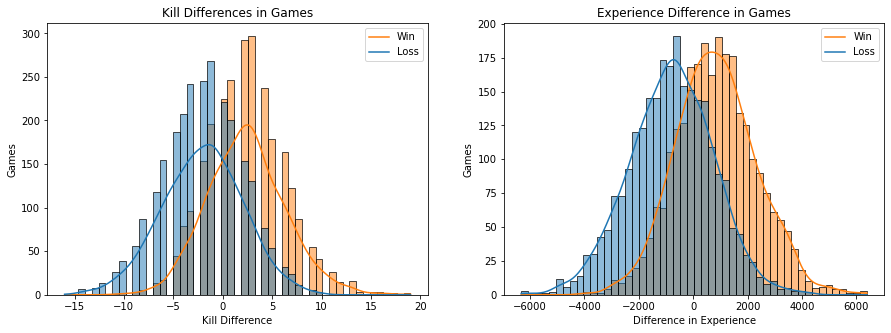

In [9]:
df['Kill Diff'] = df['Blue kills'] - df['Red kills']
df['Xp Diff'] = df['Blue xp'] - df['Red xp']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(ax = axes[0], x='Kill Diff', data=df, hue='Blue Win', kde=True)
axes[0].set(title = 'Kill Differences in Games')
axes[0].set(xlabel = 'Kill Difference', ylabel = 'Games')
axes[0].legend(labels = ['Win','Loss'])
sns.histplot(ax = axes[1], x='Xp Diff', data=df, hue='Blue Win', kde=True)
axes[1].set(title = 'Experience Difference in Games')
axes[1].set(xlabel = 'Difference in Experience', ylabel = 'Games')
axes[1].legend(labels = ['Win','Loss'])
plt.show(fig)

That's much better. When there is no difference in kills, each team has close to a 50% win rate. We can see that teams are almost guarenteed to win when teams are up 10 kills by the 10 minute mark. Teams have a median of 1150 more experience when they win. When they differ in exerience by about 3000 they tend to almost always win games. I imagine when happens when one or more person disconnects from the game which also almost guarentees a win.

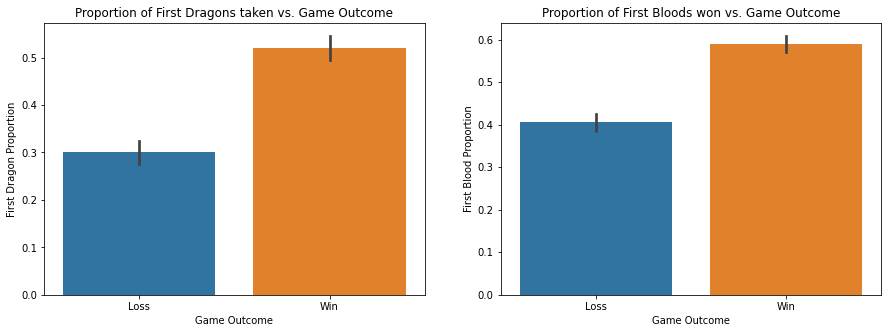

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(ax = axes[0], data=df, x= 'Blue Win', y = 'First Dragon')
axes[0].set(title = 'Proportion of First Dragons taken vs. Game Outcome')
axes[0].set(xlabel = 'Game Outcome', ylabel = 'First Dragon Proportion')
axes[0].set_xticklabels(['Loss','Win'])
sns.barplot(ax = axes[1], data=df, y='First Blood', x = 'Blue Win')
axes[1].set(title = 'Proportion of First Bloods won vs. Game Outcome')
axes[1].set(xlabel = 'Game Outcome', ylabel = 'First Blood Proportion')
axes[1].set_xticklabels(['Loss','Win'])

plt.show(fig)

There is a clear relation between slaying the first dragon, taking the first blood, and winning.

# Dimensionality Reduction

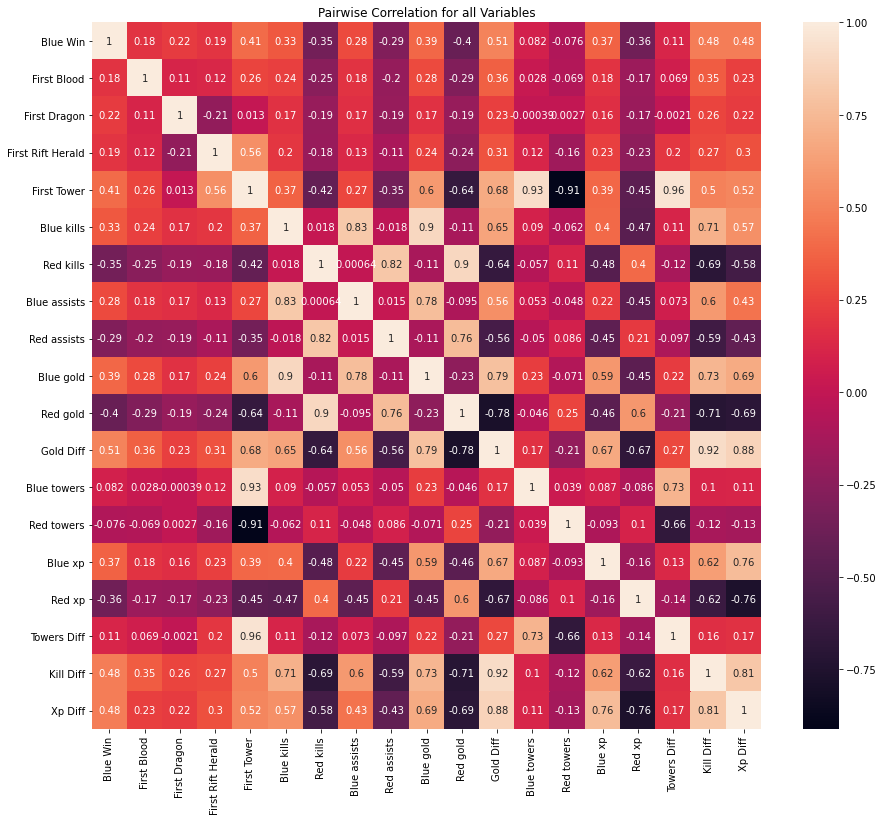

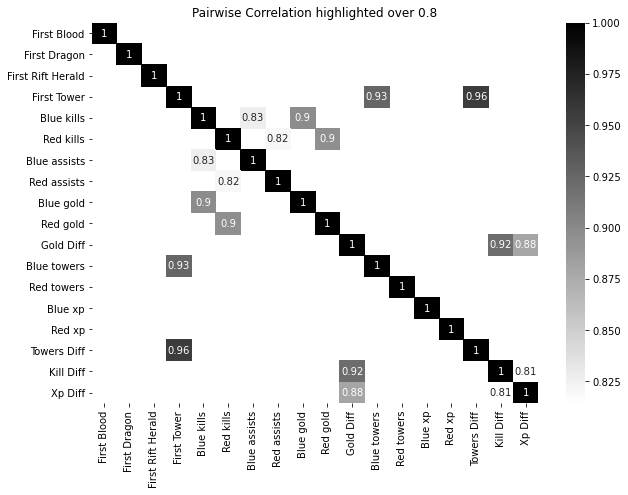

In [11]:
plt.figure(figsize=(15,13))
general = sns.heatmap(df.corr(), annot = True)
general.set(title = 'Pairwise Correlation for all Variables')
plt.show(general)
plt.figure(figsize=(10,7))
multi = sns.heatmap(df.drop('Blue Win', axis = 1).corr()[df.corr().drop('Blue Win', axis = 1) > .8], cmap = 'binary', annot = True)
multi.set(title = 'Pairwise Correlation highlighted over 0.8')
plt.show(multi)

The leading correlating variables to the game outcome are gold, kill, and experience difference. Gold difference has a correlation coefficient of 0.51 while kill and experience difference both have a correlation coefficient of 0.48.

First Tower and Blue towers have an intercorrelation of .93 while Blue towers has a correlation of .082 to Blue Win. Similarly, Towers Diff has an correlation to First Tower of .96 and has a low correlation to the target variable. We should drop Blue towers and Towers Diff to avoid multicolinearity and increase model efficiency. We should also drop Red towers due to low correlation to Blue Win. 

In [12]:
df = df.drop(['Towers Diff','Blue towers','Red towers'], axis = 1)

# Preprocessing

In [13]:
y = df['Blue Win']
X_num = df[['Blue kills','Red kills', 'Blue assists', 'Red assists','Gold Diff', 'Red gold','Blue gold','Blue xp', 'Red xp', 'Xp Diff', 'Kill Diff']]
X_cat = df[['First Blood','First Dragon','First Rift Herald','First Tower']]
X_cat = X_cat.apply(LabelEncoder().fit_transform)

scaler = MinMaxScaler()
scaler.fit(X_num)
X_num_scaled = scaler.transform(X_num)
X_num_scaled = pandas.DataFrame(X_num_scaled, index = X_num.index, columns=X_num.columns)
X_all = pandas.concat([X_num_scaled, X_cat],axis = 1)

We need to scale features for logistic regression. We'll use min max scaler for numeric features so that we can do further feature selection later. We'll also use label encoding for the categorical features since they can be ranked.

# Logistic Regression Model

In [14]:
X_train,X_test,Y_train,Y_test = train_test_split(X_all, y, test_size = 0.3, shuffle = True, random_state = 2)

In [15]:
model_lr = LogisticRegression(max_iter = 1000)
model_lr.fit(X_train, Y_train)
kf = KFold(10,shuffle = True)
scores = cross_val_score(model_lr, X_train,Y_train, cv = kf, scoring = 'accuracy') 
print('cross-val-scores: {} \n cross-val-score mean: {:.3f}'.format(scores,scores.mean()))

cross-val-scores: [0.71978022 0.75549451 0.70054945 0.73076923 0.70879121 0.71703297
 0.72252747 0.71978022 0.73901099 0.71428571] 
 cross-val-score mean: 0.723


              precision    recall  f1-score   support

       False       0.72      0.70      0.71       780
        True       0.71      0.73      0.72       780

    accuracy                           0.72      1560
   macro avg       0.72      0.72      0.72      1560
weighted avg       0.72      0.72      0.72      1560



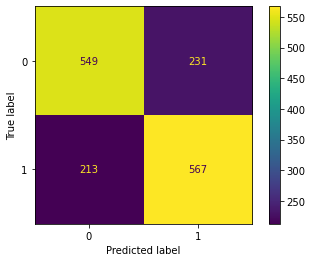

In [16]:
pred = model_lr.predict(X_test)
print(classification_report(Y_test, pred))
matrix = confusion_matrix(Y_test, pred)
confusionplot = ConfusionMatrixDisplay(matrix).plot()

# Model Building With Feature Selection

### SelectKBest

In [17]:
select_feature = SelectKBest(chi2, k = 7).fit(X_train, Y_train)

selected_features_df = pandas.DataFrame({'Feature':list(X_train.columns), 'Feature Score':select_feature.scores_})
selected_features_df.sort_values('Feature Score', ascending=False)

,Feature,Feature Score
11,First Blood,64.623973
4,Gold Diff,34.504122
10,Kill Diff,31.463397
9,Xp Diff,30.732141
1,Red kills,30.445991
0,Blue kills,29.686819
5,Red gold,28.539730
6,Blue gold,26.296629
3,Red assists,26.181509
2,Blue assists,24.957040


In [18]:
uni_train = select_feature.transform(X_train)
uni_test = select_feature.transform(X_test)

uni_model = model_lr.fit(uni_train,Y_train)
scores = cross_val_score(uni_model, uni_train, Y_train, cv = kf, scoring = 'accuracy') 
print('cross-val-scores: {} \n cross-val-score mean: {:.3f}'.format(scores,scores.mean()))

cross-val-scores: [0.71703297 0.72252747 0.70879121 0.75       0.72527473 0.72802198
 0.71153846 0.71703297 0.6978022  0.78296703] 
 cross-val-score mean: 0.726


              precision    recall  f1-score   support

       False       0.72      0.71      0.72       780
        True       0.71      0.72      0.72       780

    accuracy                           0.72      1560
   macro avg       0.72      0.72      0.72      1560
weighted avg       0.72      0.72      0.72      1560



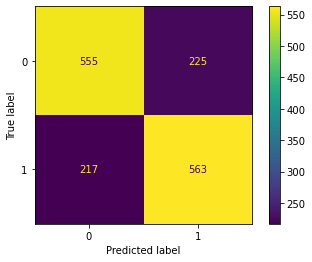

In [19]:
uni_pred = uni_model.predict(uni_test)
print(classification_report(Y_test, uni_pred))
uni_matrix = confusion_matrix(Y_test, uni_pred)
confusionplot = ConfusionMatrixDisplay(uni_matrix).plot()

### Recursive Feature Elimination

In [20]:
rfe = RFE(estimator=model_lr, step=1)
rfe = rfe.fit(X_train, Y_train)

selected_rfe_features = pandas.DataFrame({'Feature':list(X_train.columns), 'Rank':rfe.ranking_})
selected_rfe_features.sort_values(by='Rank')

,Feature,Rank
4,Gold Diff,1
5,Red gold,1
6,Blue gold,1
7,Blue xp,1
8,Red xp,1
9,Xp Diff,1
10,Kill Diff,1
0,Blue kills,2
1,Red kills,3
3,Red assists,4


In [21]:
x_train_rfe = rfe.transform(X_train)
x_test_rfe = rfe.transform(X_test)

rfe_model = model_lr.fit(x_train_rfe, Y_train)
scores = cross_val_score(rfe_model, x_train_rfe ,Y_train, cv = kf, scoring = 'accuracy') 
print('cross-val-scores: {} \n cross-val-score mean: {:.3f}'.format(scores,scores.mean()))

cross-val-scores: [0.71978022 0.71428571 0.74175824 0.73351648 0.73901099 0.72252747
 0.6978022  0.71703297 0.75824176 0.7032967 ] 
 cross-val-score mean: 0.725


              precision    recall  f1-score   support

       False       0.72      0.72      0.72       780
        True       0.72      0.72      0.72       780

    accuracy                           0.72      1560
   macro avg       0.72      0.72      0.72      1560
weighted avg       0.72      0.72      0.72      1560



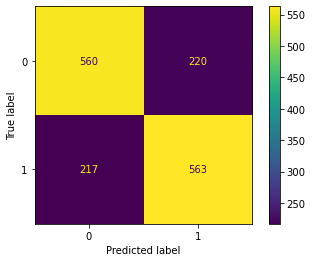

In [22]:
rfe_pred = rfe_model.predict(x_test_rfe)
print(classification_report(Y_test, rfe_pred))
rfe_matrix = confusion_matrix(Y_test, rfe_pred)
confusionplot = ConfusionMatrixDisplay(rfe_matrix).plot()

# Conclusion

The key predictors for game outcome are gold, kill, and experience difference. Winning games have a median difference of 1250 gold, 3 kills and 1000 experience. The original logistic regression model has about a cross validation accuracy mean of .720 while SelectKBest and recursive feature elimination have an accuracy mean of about .725. SelectKBest had the highest score for first blood by far however RFE ranked first blood as one of the least predictive features. Both methods agree the other categorical variables are not predictive features. 